#### Guillermo García Engelmo - Antonio Serrano Rodríguez

# PRACTICA 3 - SEGMENTACIÓN

## Visualización de muestras

Mostramos algunas imágenes del dataset junto con sus máscaras para hacernos una idea del tipo de estructuras que vamos a segmentar.



A continuación, se muestran ejemplos representativos del conjunto de datos, donde se observa la variabilidad en la forma, tamaño y posición de las regiones de fluido patológico.

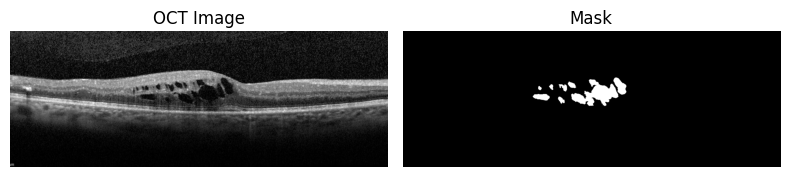

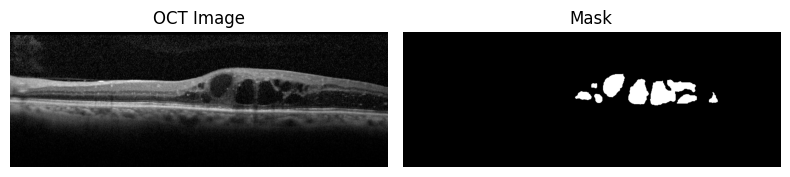

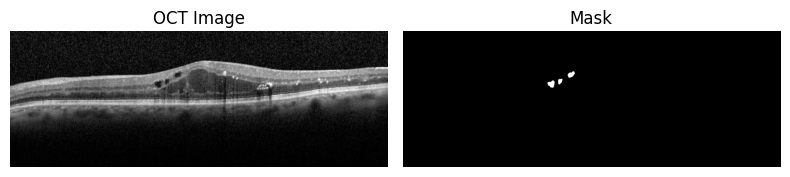

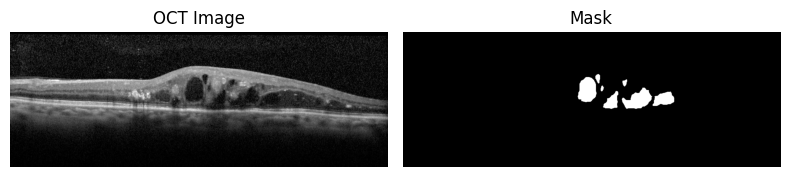

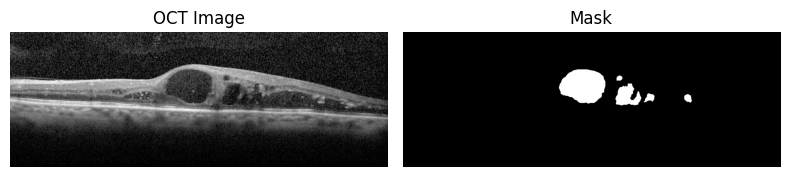

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Paths 
dataset_path = '/kaggle/input'
image_dir = dataset_path + '/oct-dataset/images'
mask_dir  = dataset_path + '/oct-dataset/masks'
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
mask_paths  = sorted(glob.glob(os.path.join(mask_dir, '*.jpg')))

# Emparejar imágenes y máscaras por nombre
pairs = list(zip(image_paths, mask_paths))

# Selección aleatoria de 5 pares imagen/máscara
sample_pairs = random.sample(pairs, min(5, len(pairs)))

for img_path, mask_path in sample_pairs:
    img  = np.array(Image.open(img_path).convert('L'))
    mask = np.array(Image.open(mask_path).convert('L'))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('OCT Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


## Estadísticas del dataset

Calculamos estadísticas por imagen para entender la distribución del tamaño de las regiones de fluido y la intensidad media de las imágenes.

Estadísticas por imagen (primeras filas):
        filename  fluid_pct  mean_intensity  std_intensity
0  sample_01.jpg   2.027953       54.864983      39.821997
1  sample_02.jpg   2.364266       46.258245      32.449735
2  sample_03.jpg   1.921252       56.969864      41.951545
3  sample_04.jpg   1.773243       37.974711      47.923712
4  sample_05.jpg   1.306023       32.957806      51.207915 

Porcentaje de región de fluido – media: 1.77%, mediana: 1.63%, desviación estándar: 1.15%
Intensidad de imagen – media de medias: 42.96, media de desviaciones estándar: 50.24



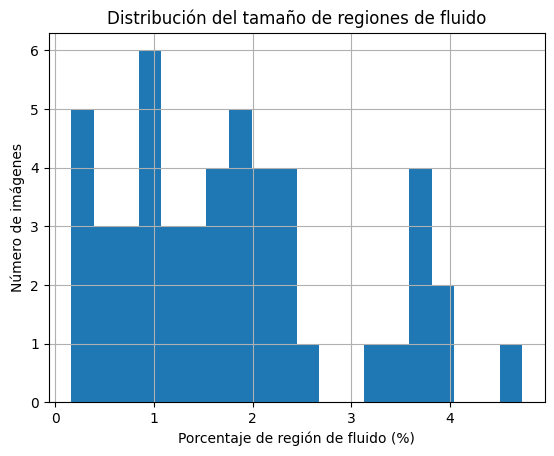

In [2]:
import pandas as pd

records = []
fluid_pcts = []
image_means = []
image_stds = []

for img_path, mask_path in pairs:
    img  = np.array(Image.open(img_path).convert('L'))
    mask = np.array(Image.open(mask_path).convert('L'))
    
    total_pix = mask.size
    fluid_pix = np.count_nonzero(mask)
    pct_fluid = fluid_pix / total_pix * 100
    mean_int  = img.mean()
    std_int   = img.std()

    records.append({
        'filename': os.path.basename(img_path),
        'fluid_pct': pct_fluid,
        'mean_intensity': mean_int,
        'std_intensity': std_int
    })
    
    fluid_pcts.append(pct_fluid)
    image_means.append(mean_int)
    image_stds.append(std_int)

df = pd.DataFrame.from_records(records)

# Mostrar resumen
print("Estadísticas por imagen (primeras filas):")
print(df.head(), "\n")

print(f"Porcentaje de región de fluido – media: {np.mean(fluid_pcts):.2f}%, "
      f"mediana: {np.median(fluid_pcts):.2f}%, "
      f"desviación estándar: {np.std(fluid_pcts):.2f}%")
print(f"Intensidad de imagen – media de medias: {np.mean(image_means):.2f}, "
      f"media de desviaciones estándar: {np.mean(image_stds):.2f}\n")

# Histograma
plt.figure()
plt.hist(fluid_pcts, bins=20)
plt.xlabel('Porcentaje de región de fluido (%)')
plt.ylabel('Número de imágenes')
plt.title('Distribución del tamaño de regiones de fluido')
plt.grid(True)
plt.show()


El análisis del conjunto de datos revela una fuerte desproporción entre fondo y regiones de fluido. En promedio, las regiones patológicas ocupan solo un 1.77% de los píxeles por imagen, con una desviación estándar del 1.15%. Esto justifica el uso de funciones de pérdida adaptadas a clases desbalanceadas, como DiceLoss.

## Creación del dataset 

Definimos una clase personalizada `OCTDataset` que se encarga de cargar y procesar las imágenes OCT y sus máscaras correspondientes.

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset 
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random
import cv2

class OCTDataset(Dataset):
    
    def __init__(self, image_path, mask_path, rsize = (416,624), transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.jpg'))

        self.mask_files = []

        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path, os.path.basename(img_path)))
                
        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY) # Make sure that mask is binary
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed) 
            image = self.transform(image)
            random.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed) 
            mask = self.transform(mask)
        else:
            t = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST),
                transforms.ToTensor()])

            image = t(image)
            mask = t(mask)
        
        return image, mask

    def __len__(self):
        return len(self.img_files)


## División del dataset y augmentation

- El dataset se divide en train/val/test (70/15/15).
- Se aplica augmentación sensata para OCT en el conjunto de entrenamiento:
rotación leve, giro horizontal, ajustes de brillo/contraste y desenfoque, simulando variaciones comunes en la adquisición.

In [ ]:
import torch
T_SHAPE = (416,624)
# Carga y define dataset una vez
dataset = OCTDataset(image_path= image_dir,
                     mask_path= mask_dir, rsize = T_SHAPE)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(T_SHAPE, interpolation=InterpolationMode.NEAREST),

    # AUGMENTATION 
    transforms.RandomHorizontalFlip(p=0.5),                   # simula inversión entre ojos 
    transforms.RandomRotation(degrees=10, interpolation=InterpolationMode.NEAREST),  # rotación leve aceptable
    transforms.ColorJitter(brightness=0.1, contrast=0.1),     # simula variabilidad del escáner
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)), # ruido/desenfoque leve, como baja calidad de adquisición

    transforms.ToTensor()
])
print(f"Número total de muestras: {len(dataset)}")

# División
BATCH_SIZE = 4
num_total = len(dataset)
num_train = int(0.7 * num_total)
num_val = int(0.15 * num_total)
num_test = num_total - num_train - num_val

print(f"División: Train={num_train}, Val={num_val}, Test={num_test}")

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(42)
)

train_idxs = train_set.indices

train_ds_aug = Subset(
    OCTDataset(image_path=image_dir,
               mask_path=mask_dir,
               transform=train_transform),
    train_idxs
)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_augmentated_loader = torch.utils.data.DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


Número total de muestras: 50
División: Train=35, Val=7, Test=8


## Métrica de evaluación Dice

Usamos la métrica Dice para medir la superposición entre la máscara predicha y la real, especialmente útil cuando hay desbalance de clases.


In [5]:
def dice_coef(pred, target, eps=1e-6):
    pred, target = pred.float(), target.float()
    inter = (pred * target).sum()
    return (2 * inter + eps) / (pred.sum() + target.sum() + eps)

## Definimos modelo

In [6]:
import torch.nn as nn

def double_conv(in_channels, out_channels, bn = False):
    if bn:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, 3, padding = 1),
        nn.ReLU(inplace = True),
    )



class UNet(nn.Module):
    def __init__(self, input_channels, n_class, use_bn=False):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64, bn=use_bn)
        self.dconv_down2 = double_conv(64, 128, bn=use_bn)
        self.dconv_down3 = double_conv(128, 256, bn=use_bn)
        self.dconv_down4 = double_conv(256, 512, bn=use_bn)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256, bn=use_bn)
        self.dconv_up2 = double_conv(128 + 256, 128, bn=use_bn)
        self.dconv_up1 = double_conv(128 + 64, 64, bn=use_bn)

        self.conv_last = nn.Conv2d(64, n_class, 1)

        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

## Funciones auxiliares:

- get_segmentation_masks: convierte la salida continua del modelo en máscaras binarias aplicando una función sigmoidea y un umbral.

- show_result: visualiza la imagen original, la máscara real (GT), la predicción y su solapamiento (GT * pred) para facilitar la inspección cualitativa del resultado.

In [ ]:
# Aux function to get binary segmentation mask
import torch
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold)*1.0
    return masks

# Aux function to show results
def show_result(orig, gt, prediction, title=None):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    ax = axes.ravel()

    images = [orig, gt, prediction, gt*prediction]
    titles = ['Orig', 'Gt', 'Result', 'Overlap']
    for i, (im, tit) in enumerate(zip(images, titles)):
        ax[i].imshow(im, cmap='gray')
        ax[i].set_title(tit)
        ax[i].axis('off')
    plt.show()

## Funciones de pérdida

Se definen varias funciones adaptadas a la segmentación binaria con datos desbalanceados:

- DiceLoss: métrica basada en la superposición, eficaz en clases pequeñas.

- BCEDiceLoss: combina BCE y Dice para equilibrar sensibilidad y precisión.

- FocalLoss: penaliza errores en muestras difíciles (útil en fuerte desbalance).

- TverskyLoss: generaliza Dice ponderando falsos positivos/negativos.

- Weighted BCE: aplica un peso a la clase positiva según su proporción.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        target = target.float()
        inter = (pred * target).sum(dim=(1,2,3))
        union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
        dice = (2 * inter + self.eps) / (union + self.eps)
        return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.3):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + (1 - self.bce_weight) * self.dice(pred, target)



class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        target = target.float()
        bce_loss = F.binary_cross_entropy_with_logits(logits, target, reduction='none')
        prob = torch.sigmoid(logits)
        p_t = prob * target + (1 - prob) * (1 - target)
        mod_factor = (1 - p_t) ** self.gamma
        alpha_factor = self.alpha * target + (1 - self.alpha) * (1 - target)
        loss = alpha_factor * mod_factor * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    def forward(self, logits, target):
        pred = torch.sigmoid(logits)
        target = target.float()
        dims = tuple(range(1, target.dim()))
        TP = (pred * target).sum(dim=dims)
        FN = ((1 - pred) * target).sum(dim=dims)
        FP = (pred * (1 - target)).sum(dim=dims)
        tversky_index = (TP + self.eps) / (TP + self.alpha * FN + self.beta * FP + self.eps)
        loss = 1 - tversky_index
        return loss.mean()


class WeightedBCELoss(nn.Module):
    def __init__(self, pos_ratio: float = 0.2, reduction: str = 'mean'):
        super().__init__()
        if not 0 < pos_ratio < 1:
            raise ValueError("pos_ratio debe estar en (0,1)")
        neg_ratio = 1.0 - pos_ratio
        # Registramos pos_weight como buffer
        self.register_buffer('pos_weight',
                             torch.tensor([neg_ratio / pos_ratio], dtype=torch.float))
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return F.binary_cross_entropy_with_logits(
            logits,
            target.float(),
            pos_weight=self.pos_weight,
            reduction=self.reduction
        )

## Entrenamiento + validación

#### Early Stopping
Se implementa una estrategia de early stopping para evitar sobreentrenamiento.
El entrenamiento se detiene si no mejora la métrica de validación tras varias épocas (patience).
Además, puede restaurar los mejores pesos observados si restore_best_weights=True.



In [9]:
class EarlyStopping:
  def __init__(self, patience = 3, min_delta = 0.0, restore_best_weights = False):
    self.patience = patience  # Máximas epochs sin mejora
    self.tilt = 0 # Contador de patience
    self.min_delta = min_delta  # Diferencia mínima para considerar que el modelo empeora
    self.best_observed_metric = float("inf")  # Inf ya que lo vamos a comparar
    self.restore_best_weights = restore_best_weights  # Bool que indica si se cargan los mejores pesos al activarse el callback
    if restore_best_weights:
      self.best_weights = None  # Los mejores pesos

  def __call__(self, metric, model):
    if metric < self.best_observed_metric - self.min_delta:
      self.best_observed_metric = metric  # Actualizar la mejor métrica
      self.tilt = 0 # Reiniciar contador
      if self.restore_best_weights:
        self.best_weights = model.state_dict()  # Guardar los nuevos mejores pesos
    else:
      self.tilt += 1  # Aumentar contador
      if self.tilt == self.patience:  # Comprobar si se activa el callback
        if self.restore_best_weights:
          model.load_state_dict(self.best_weights)  # Restaurar los mejores pesos
        return True
    return False

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                num_epochs=20, threshold=0.5, save_path=None, early_stopper=None):
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validación
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = get_segmentation_masks(outputs, threshold=threshold)
                val_dice += dice_coef(preds, masks).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Dice: {avg_val_dice:.4f}")

        # Early stopping por val_loss
        if early_stopper is not None:
            stop = early_stopper(avg_val_loss, model)
            if stop:
                print(" Entrenamiento detenido por early stopping.")
                break

    print("Entrenamiento finalizado.")
    return model


## Evaluación del modelo

Se calcula el rendimiento del modelo en el conjunto de test mediante métricas estándar para segmentación binaria:

- Precision, Recall y Specificity

- Dice coefficient y IoU (superposición de máscaras)

Las métricas se obtienen a partir de los resultados binarizados (threshold=0.5) y se muestran junto con ejemplos visuales para facilitar su interpretación.

In [11]:
from sklearn.metrics import precision_score, recall_score,jaccard_score, confusion_matrix

def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    precision = precision_score(target, pred, zero_division=0)
    recall    = recall_score(target, pred, zero_division=0)
    iou       = jaccard_score(target, pred, zero_division=0)
    dice      = (2 * (pred * target).sum()) / (pred.sum() + target.sum() + 1e-6)
    tn, fp, fn, tp = confusion_matrix(target, pred, labels=[0,1]).ravel()
    specificity = tn / (tn + fp + 1e-6)

    return {
        "precision": precision,
        "recall": recall,
        "iou": iou,
        "dice": dice,
        "specificity": specificity
    }



In [12]:
import torch
import numpy as np


def evaluate_model(model, test_loader, device, threshold=0.5, num_examples=3):
    model.eval()
    metrics_accum = {
    "precision": 0.0, "recall": 0.0,
    "iou": 0.0, "dice": 0.0,
    "specificity": 0.0
    }
    total_batches = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = get_segmentation_masks(outputs, threshold=threshold)

            for i in range(images.size(0)):
                batch_metrics = compute_metrics(preds[i][0], masks[i][0])
                for k in metrics_accum:
                    metrics_accum[k] += batch_metrics[k]
                total_batches += 1

                if num_examples > 0:
                    show_result(
                        orig=images[i][0].cpu().numpy(),
                        gt=masks[i][0].cpu().numpy(),
                        prediction=preds[i][0].cpu().numpy()
                    )
                    num_examples -= 1
            if num_examples <= 0:
                break

    print("\n Métricas en test:")
    for k in metrics_accum:
        print(f"{k.capitalize()}: {metrics_accum[k]/total_batches:.4f}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Baseline – UNet + Weighted BCE

Se establece la línea base usando una UNet estándar con pérdida WBCE para compensar el desbalance del dataset. Se entrena con early stopping y se evalúa con umbral 0.5. Servirá como punto de comparación frente a las mejoras posteriores.

Epoch 1/200 | Train Loss: 0.6667 | Val Loss: 0.3749 | Val Dice: 0.0000
Epoch 2/200 | Train Loss: 0.3104 | Val Loss: 0.2293 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.2448 | Val Loss: 0.2187 | Val Dice: 0.0000
Epoch 4/200 | Train Loss: 0.2357 | Val Loss: 0.2134 | Val Dice: 0.0000
Epoch 5/200 | Train Loss: 0.2313 | Val Loss: 0.2107 | Val Dice: 0.0000
Epoch 6/200 | Train Loss: 0.2285 | Val Loss: 0.2068 | Val Dice: 0.0000
Epoch 7/200 | Train Loss: 0.2237 | Val Loss: 0.2016 | Val Dice: 0.0000
Epoch 8/200 | Train Loss: 0.2226 | Val Loss: 0.1952 | Val Dice: 0.0000
Epoch 9/200 | Train Loss: 0.2168 | Val Loss: 0.2007 | Val Dice: 0.0000
Epoch 10/200 | Train Loss: 0.2138 | Val Loss: 0.1714 | Val Dice: 0.0000
Epoch 11/200 | Train Loss: 0.1779 | Val Loss: 0.1381 | Val Dice: 0.0000
Epoch 12/200 | Train Loss: 0.1680 | Val Loss: 0.1430 | Val Dice: 0.0000
Epoch 13/200 | Train Loss: 1.0292 | Val Loss: 0.2433 | Val Dice: 0.0000
Epoch 14/200 | Train Loss: 0.3036 | Val Loss: 0.2188 | Val Dice: 0.0000
E

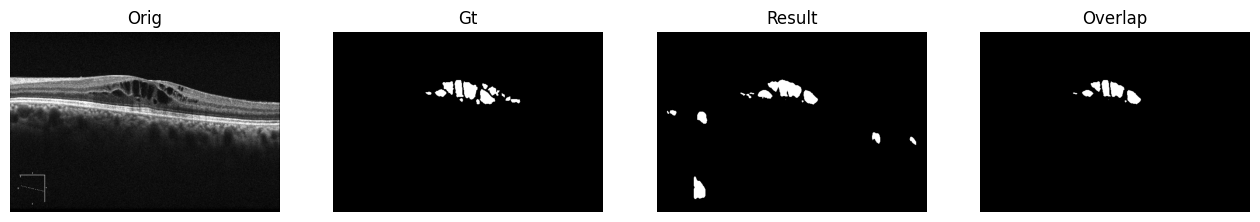

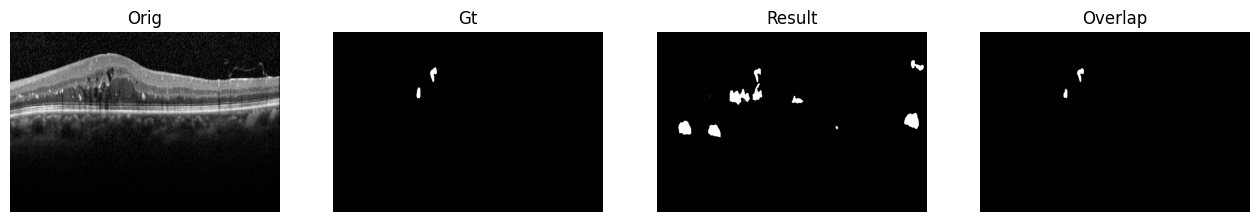

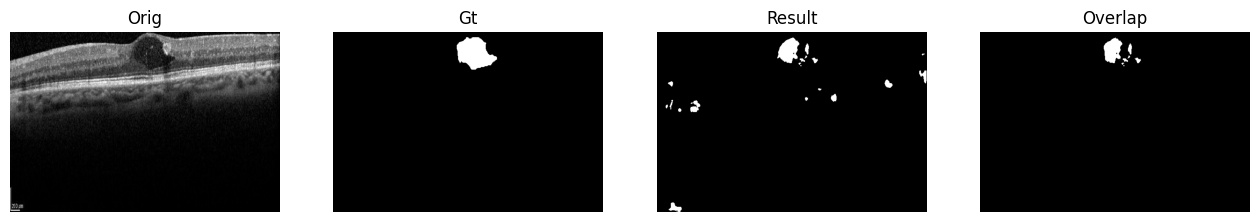


 Métricas en test:
Precision: 0.3650
Recall: 0.7429
Iou: 0.2903
Dice: 0.4346
Specificity: 0.9861


In [13]:
baseline = UNet(1, 1).to(device)
criterion = WeightedBCELoss(pos_ratio=0.2).to(device)
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    baseline, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("Baseline: Unet with  WeightedBCELoss")
evaluate_model(baseline, test_loader, device, threshold=0.5, num_examples=3)

## UNet + Dice Loss

Se sustituye la pérdida WBCE por Dice Loss, más adecuada para tareas de segmentación con clases desbalanceadas. Evalúa directamente la superposición entre predicción y máscara. Esta mejora conduce a un aumento claro del Dice y del IoU respecto al baseline

Epoch 1/200 | Train Loss: 0.9695 | Val Loss: 0.9712 | Val Dice: 0.1036
Epoch 2/200 | Train Loss: 0.9610 | Val Loss: 0.9403 | Val Dice: 0.1126
Epoch 3/200 | Train Loss: 0.8529 | Val Loss: 0.6003 | Val Dice: 0.5127
Epoch 4/200 | Train Loss: 0.6691 | Val Loss: 0.5496 | Val Dice: 0.5206
Epoch 5/200 | Train Loss: 0.5133 | Val Loss: 0.4445 | Val Dice: 0.6156
Epoch 6/200 | Train Loss: 0.5028 | Val Loss: 0.3836 | Val Dice: 0.6848
Epoch 7/200 | Train Loss: 0.4544 | Val Loss: 0.3392 | Val Dice: 0.7455
Epoch 8/200 | Train Loss: 0.5406 | Val Loss: 0.2804 | Val Dice: 0.7802
Epoch 9/200 | Train Loss: 0.4282 | Val Loss: 0.2758 | Val Dice: 0.7859
Epoch 10/200 | Train Loss: 0.4098 | Val Loss: 0.3116 | Val Dice: 0.7546
Epoch 11/200 | Train Loss: 0.3682 | Val Loss: 0.3563 | Val Dice: 0.6884
Epoch 12/200 | Train Loss: 0.3434 | Val Loss: 0.2416 | Val Dice: 0.8196
Epoch 13/200 | Train Loss: 0.2994 | Val Loss: 0.2796 | Val Dice: 0.7637
Epoch 14/200 | Train Loss: 0.3250 | Val Loss: 0.2365 | Val Dice: 0.8114
E

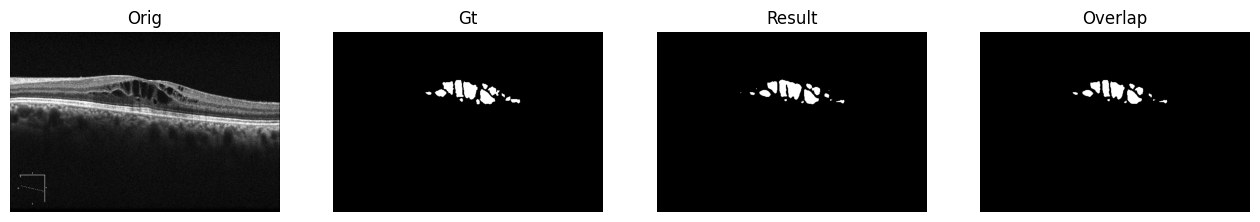

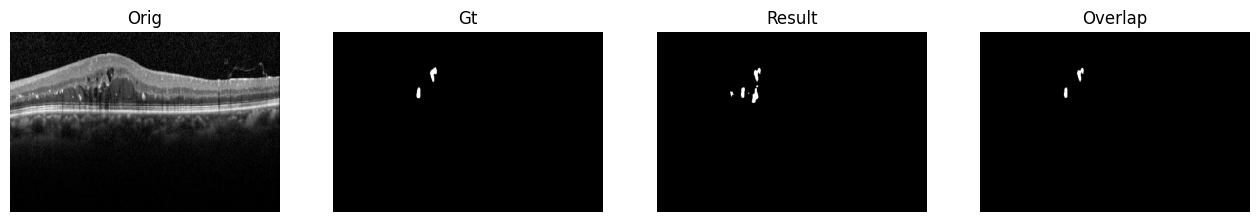

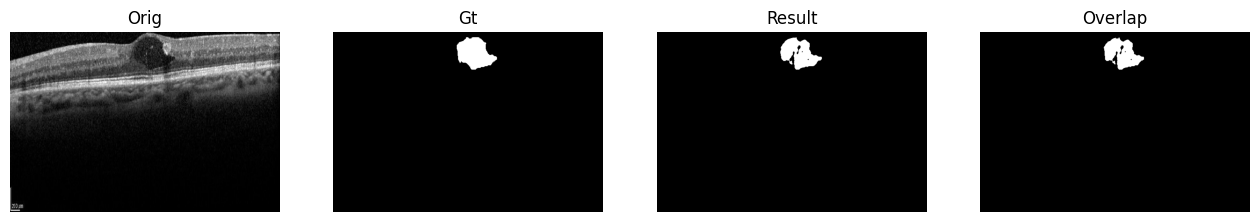


 Métricas en test:
Precision: 0.8123
Recall: 0.8893
Iou: 0.7355
Dice: 0.8374
Specificity: 0.9987


In [ ]:
dice_model = UNet(1, 1).to(device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(dice_model.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    dice_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("1º exp: Unet with Dice loss")
evaluate_model(dice_model, test_loader, device, threshold=0.5, num_examples=3)

## UNet + BCE + Dice Loss

Se combina BCE con Dice Loss para equilibrar penalización local y global. Aunque mejora respecto al baseline, no supera el rendimiento obtenido con Dice Loss en solitario.

Epoch 1/200 | Train Loss: 0.8064 | Val Loss: 0.7392 | Val Dice: 0.0000
Epoch 2/200 | Train Loss: 0.7297 | Val Loss: 0.7195 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.7139 | Val Loss: 0.7111 | Val Dice: 0.0000
Epoch 4/200 | Train Loss: 0.7115 | Val Loss: 0.7074 | Val Dice: 0.0000
Epoch 5/200 | Train Loss: 0.7062 | Val Loss: 0.6945 | Val Dice: 0.0000
Epoch 6/200 | Train Loss: 0.7029 | Val Loss: 0.6880 | Val Dice: 0.0000
Epoch 7/200 | Train Loss: 0.6972 | Val Loss: 0.6770 | Val Dice: 0.0000
Epoch 8/200 | Train Loss: 0.6975 | Val Loss: 0.6667 | Val Dice: 0.0000
Epoch 9/200 | Train Loss: 0.6190 | Val Loss: 0.6420 | Val Dice: 0.0000
Epoch 10/200 | Train Loss: 0.5721 | Val Loss: 0.4718 | Val Dice: 0.4769
Epoch 11/200 | Train Loss: 0.5219 | Val Loss: 0.4383 | Val Dice: 0.6337
Epoch 12/200 | Train Loss: 0.4286 | Val Loss: 0.3213 | Val Dice: 0.6519
Epoch 13/200 | Train Loss: 0.3210 | Val Loss: 0.2695 | Val Dice: 0.7072
Epoch 14/200 | Train Loss: 0.3279 | Val Loss: 0.2302 | Val Dice: 0.7551
E

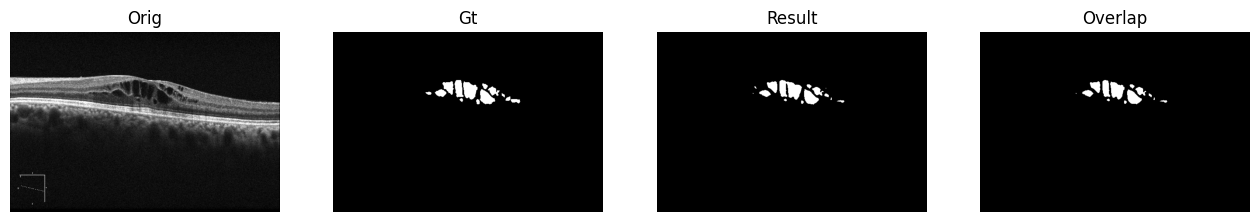

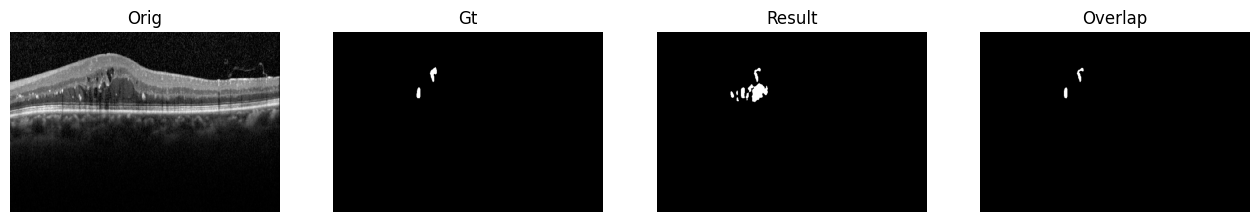

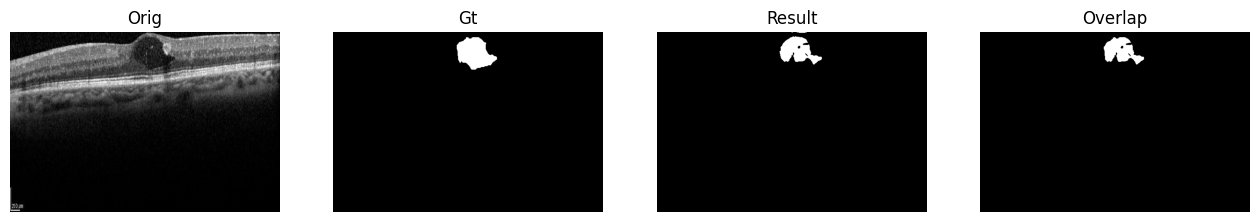


 Métricas en test:
Precision: 0.7273
Recall: 0.8374
Iou: 0.6254
Dice: 0.7350
Specificity: 0.9976


In [13]:
BCED_model = UNet(1, 1).to(device)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(BCED_model.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    BCED_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("2ª exp: Unet with BCEDiceLoss")
evaluate_model(BCED_model, test_loader, device, threshold=0.5, num_examples=3)

## UNet + Focal Loss

Se prueba Focal Loss, diseñada para penalizar más los errores en clases minoritarias. Aunque mejora notablemente la precisión, sacrifica recall y obtiene peor Dice que DiceLoss o BCE+Dice, por lo que no supera los mejores resultados previos.

Epoch 1/200 | Train Loss: 0.0436 | Val Loss: 0.0089 | Val Dice: 0.0000
Epoch 2/200 | Train Loss: 0.0087 | Val Loss: 0.0075 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.0082 | Val Loss: 0.0072 | Val Dice: 0.0000
Epoch 4/200 | Train Loss: 0.0078 | Val Loss: 0.0070 | Val Dice: 0.0000
Epoch 5/200 | Train Loss: 0.0078 | Val Loss: 0.0069 | Val Dice: 0.0000
Epoch 6/200 | Train Loss: 0.0076 | Val Loss: 0.0067 | Val Dice: 0.0000
Epoch 7/200 | Train Loss: 0.0075 | Val Loss: 0.0066 | Val Dice: 0.0000
Epoch 8/200 | Train Loss: 0.0077 | Val Loss: 0.0065 | Val Dice: 0.0000
Epoch 9/200 | Train Loss: 0.0076 | Val Loss: 0.0071 | Val Dice: 0.0000
Epoch 10/200 | Train Loss: 0.0077 | Val Loss: 0.0067 | Val Dice: 0.0000
Epoch 11/200 | Train Loss: 0.0076 | Val Loss: 0.0065 | Val Dice: 0.0000
Epoch 12/200 | Train Loss: 0.0075 | Val Loss: 0.0064 | Val Dice: 0.0000
Epoch 13/200 | Train Loss: 0.0077 | Val Loss: 0.0071 | Val Dice: 0.0000
Epoch 14/200 | Train Loss: 0.0073 | Val Loss: 0.0067 | Val Dice: 0.0000
E

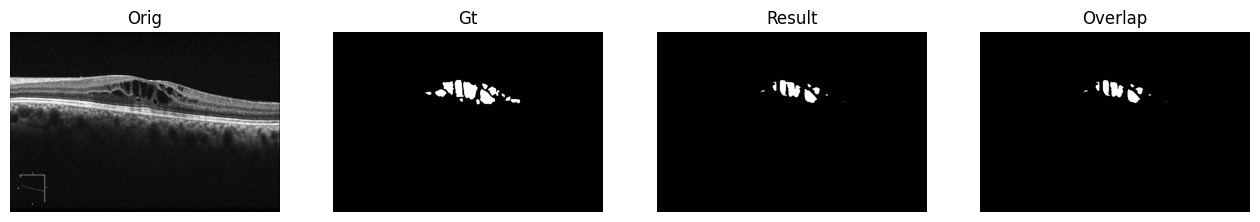

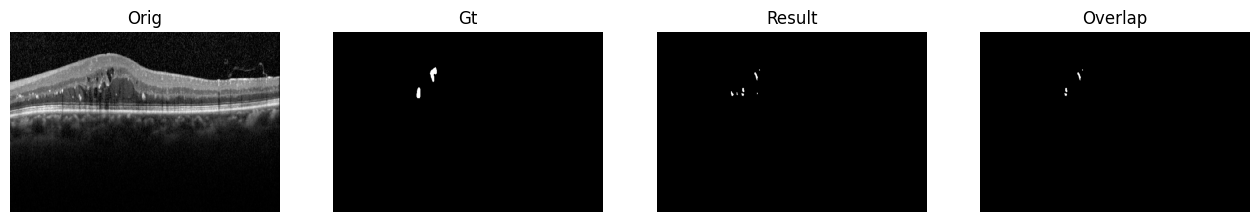

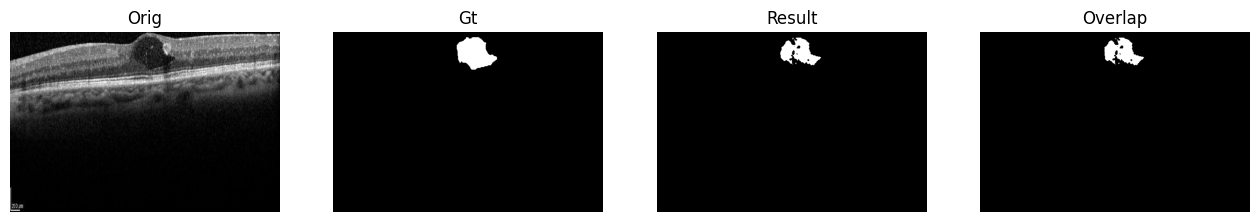


 Métricas en test:
Precision: 0.8958
Recall: 0.6027
Iou: 0.5745
Dice: 0.7046
Specificity: 0.9996


In [13]:
FL_model = UNet(1, 1).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(FL_model.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    FL_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("3ª exp: Unet with FocalLoss")
evaluate_model(FL_model, test_loader, device, threshold=0.5, num_examples=3)

## UNet + Tversky Loss

Se utiliza Tversky Loss, una generalización de Dice que permite ajustar el peso de falsos positivos y negativos. Ofrece un rendimiento equilibrado y competitivo, aunque ligeramente inferior al de DiceLoss en solitario.


Epoch 1/200 | Train Loss: 0.9694 | Val Loss: 0.9701 | Val Dice: 0.0180
Epoch 2/200 | Train Loss: 0.9478 | Val Loss: 0.8710 | Val Dice: 0.2277
Epoch 3/200 | Train Loss: 0.7485 | Val Loss: 0.4833 | Val Dice: 0.6116
Epoch 4/200 | Train Loss: 0.7226 | Val Loss: 0.7043 | Val Dice: 0.3554
Epoch 5/200 | Train Loss: 0.8180 | Val Loss: 0.6181 | Val Dice: 0.4329
Epoch 6/200 | Train Loss: 0.6148 | Val Loss: 0.4743 | Val Dice: 0.5838
Epoch 7/200 | Train Loss: 0.5194 | Val Loss: 0.3450 | Val Dice: 0.7102
Epoch 8/200 | Train Loss: 0.4702 | Val Loss: 0.4530 | Val Dice: 0.5968
Epoch 9/200 | Train Loss: 0.4160 | Val Loss: 0.3385 | Val Dice: 0.7113
Epoch 10/200 | Train Loss: 0.4475 | Val Loss: 0.3685 | Val Dice: 0.6941
Epoch 11/200 | Train Loss: 0.4007 | Val Loss: 0.4534 | Val Dice: 0.5972
Epoch 12/200 | Train Loss: 0.3772 | Val Loss: 0.3325 | Val Dice: 0.7308
Epoch 13/200 | Train Loss: 0.3688 | Val Loss: 0.3211 | Val Dice: 0.7139
Epoch 14/200 | Train Loss: 0.3712 | Val Loss: 0.3998 | Val Dice: 0.6271
E

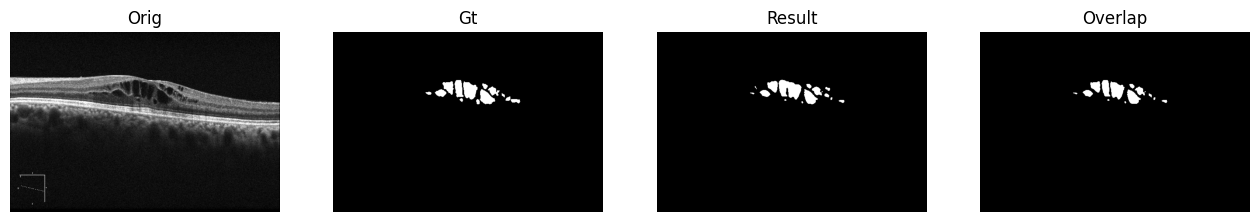

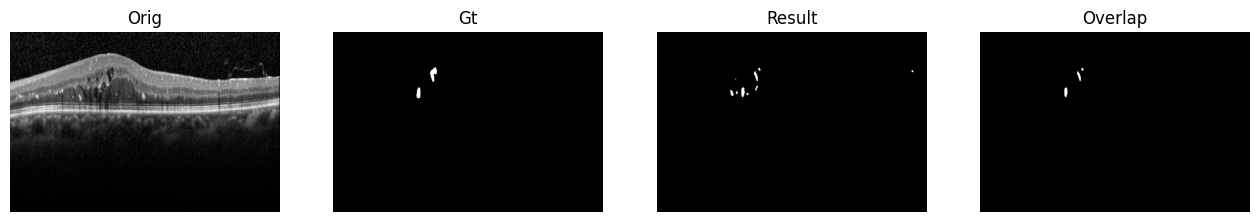

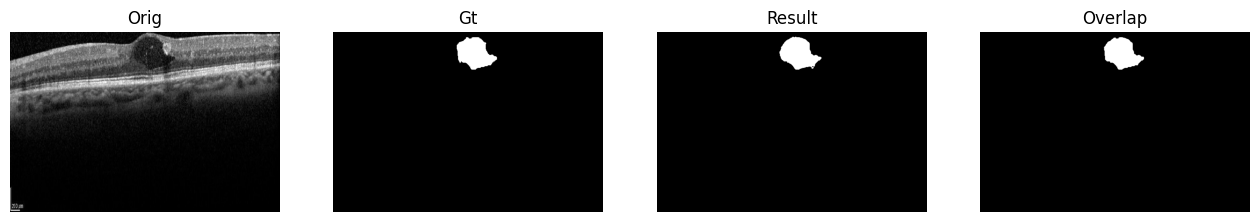


 Métricas en test:
Precision: 0.8164
Recall: 0.8297
Iou: 0.7203
Dice: 0.8198
Specificity: 0.9987


In [14]:
TL_model = UNet(1, 1).to(device)
criterion = TverskyLoss()
optimizer = torch.optim.Adam(TL_model.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    TL_model, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("3ª exp: Unet with FocalLoss")
evaluate_model(TL_model, test_loader, device, threshold=0.5, num_examples=3)

## UNet + Tversky Loss + Augmentation
Se añade data augmentation al entrenamiento para mejorar la generalización del modelo. Aunque se incrementa el recall, el rendimiento global no supera al uso de Tversky o DiceLoss sin augmentación, lo que sugiere que el aumento no aporta valor directo en este conjunto.

Epoch 1/200 | Train Loss: 0.9707 | Val Loss: 0.9702 | Val Dice: 0.0282
Epoch 2/200 | Train Loss: 0.9690 | Val Loss: 0.9683 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.9520 | Val Loss: 0.8940 | Val Dice: 0.1189
Epoch 4/200 | Train Loss: 0.8776 | Val Loss: 0.9340 | Val Dice: 0.0660
Epoch 5/200 | Train Loss: 0.8325 | Val Loss: 0.5915 | Val Dice: 0.4636
Epoch 6/200 | Train Loss: 0.6271 | Val Loss: 0.5284 | Val Dice: 0.5482
Epoch 7/200 | Train Loss: 0.5761 | Val Loss: 0.5126 | Val Dice: 0.5310
Epoch 8/200 | Train Loss: 0.5743 | Val Loss: 0.4482 | Val Dice: 0.6174
Epoch 9/200 | Train Loss: 0.5135 | Val Loss: 0.5579 | Val Dice: 0.4722
Epoch 10/200 | Train Loss: 0.5277 | Val Loss: 0.4125 | Val Dice: 0.6573
Epoch 11/200 | Train Loss: 0.4913 | Val Loss: 0.3868 | Val Dice: 0.6654
Epoch 12/200 | Train Loss: 0.4917 | Val Loss: 0.3430 | Val Dice: 0.7184
Epoch 13/200 | Train Loss: 0.4668 | Val Loss: 0.3287 | Val Dice: 0.7145
Epoch 14/200 | Train Loss: 0.4183 | Val Loss: 0.3100 | Val Dice: 0.7644
E

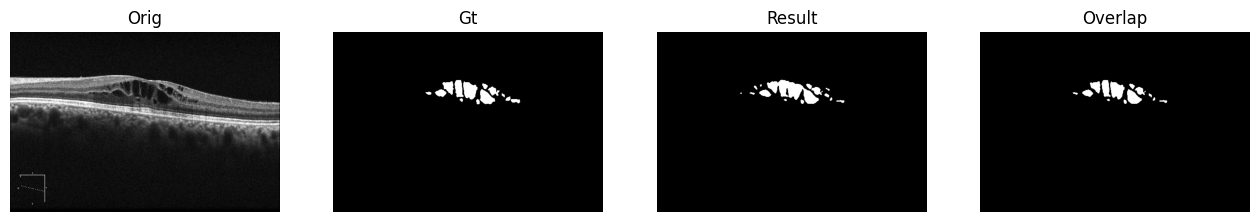

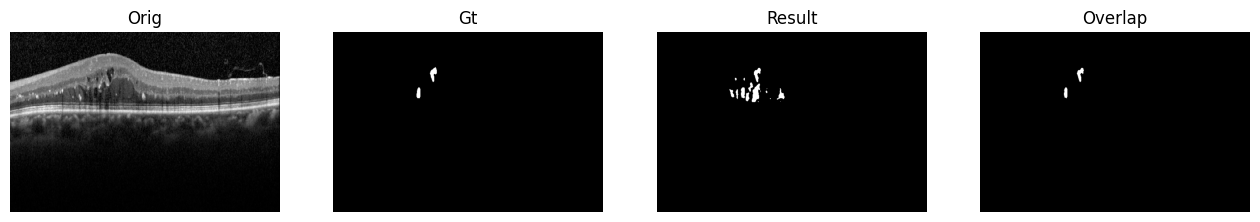

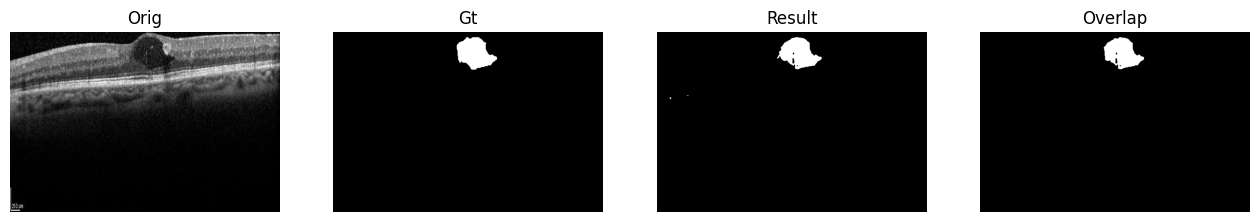


 Métricas en test:
Precision: 0.7158
Recall: 0.9223
Iou: 0.6746
Dice: 0.7727
Specificity: 0.9973


In [32]:
model_aug = UNet(1, 1).to(device)
criterion = TverskyLoss()
optimizer = torch.optim.Adam(model_aug.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    model_aug,
    train_augmentated_loader,  
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("UNet + TverskyLoss + Augmentation")
evaluate_model(model_aug, test_loader, device, threshold=0.2, num_examples=3)


## UNet + Tversky Loss + BatchNorm
Se introduce Batch Normalization para estabilizar y acelerar el entrenamiento. El modelo logra una alta precisión, pero a costa de menor recall y una reducción general del Dice respecto al uso de Tversky sin normalización.

Epoch 1/200 | Train Loss: 0.9555 | Val Loss: 0.9760 | Val Dice: 0.0000
Epoch 2/200 | Train Loss: 0.9336 | Val Loss: 0.9726 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.9133 | Val Loss: 0.9498 | Val Dice: 0.0975
Epoch 4/200 | Train Loss: 0.8977 | Val Loss: 0.9174 | Val Dice: 0.1825
Epoch 5/200 | Train Loss: 0.8695 | Val Loss: 0.8987 | Val Dice: 0.2905
Epoch 6/200 | Train Loss: 0.8442 | Val Loss: 0.9303 | Val Dice: 0.0824
Epoch 7/200 | Train Loss: 0.8190 | Val Loss: 0.9025 | Val Dice: 0.1201
Epoch 8/200 | Train Loss: 0.7647 | Val Loss: 0.7667 | Val Dice: 0.6617
Epoch 9/200 | Train Loss: 0.7082 | Val Loss: 0.9463 | Val Dice: 0.0547
Epoch 10/200 | Train Loss: 0.6480 | Val Loss: 0.6100 | Val Dice: 0.7300
Epoch 11/200 | Train Loss: 0.6370 | Val Loss: 0.6731 | Val Dice: 0.5531
Epoch 12/200 | Train Loss: 0.5546 | Val Loss: 0.6813 | Val Dice: 0.4379
Epoch 13/200 | Train Loss: 0.4812 | Val Loss: 0.6090 | Val Dice: 0.5159
Epoch 14/200 | Train Loss: 0.4446 | Val Loss: 0.5679 | Val Dice: 0.5128
E

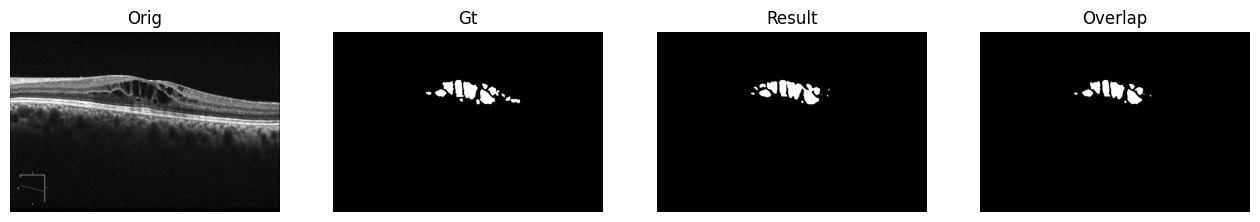

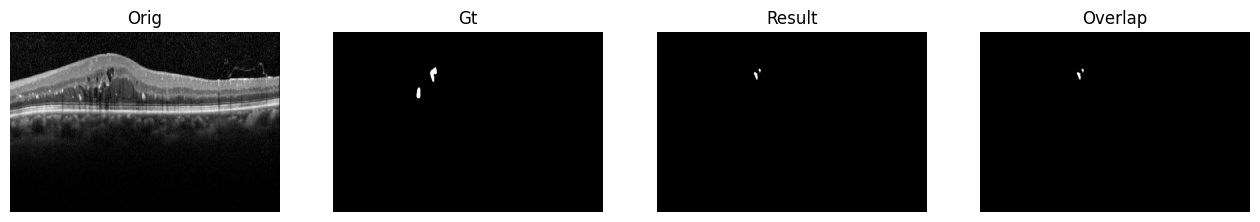

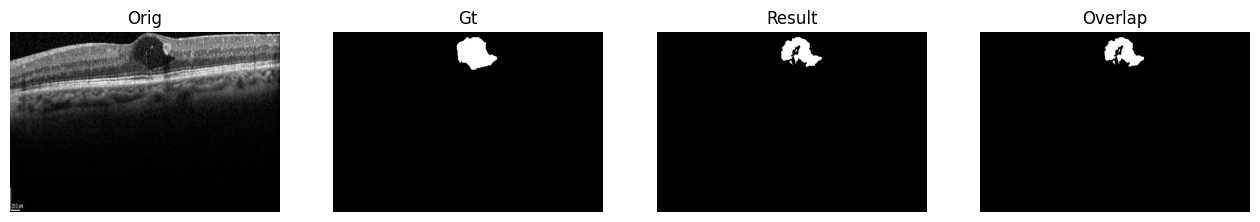


 Métricas en test:
Precision: 0.9128
Recall: 0.7004
Iou: 0.6277
Dice: 0.7442
Specificity: 0.9988


In [29]:
model_bn = UNet(1, 1, use_bn=True).to(device)
criterion = TverskyLoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    model_bn, train_loader, val_loader,
    TverskyLoss(), optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("UNet + TverskyLoss + BatchNorm")
evaluate_model(model_bn, test_loader, device, threshold=0.5, num_examples=3)


## UNet + Tversky Loss + Augmentation + BatchNorm
Se combinan data augmentation y Batch Normalization con Tversky Loss para reforzar la generalización. Sin embargo, el rendimiento no mejora respecto a usar Tversky por sí solo y sigue lejos del mejor resultado global, obtenido con DiceLoss.

Epoch 1/200 | Train Loss: 0.9603 | Val Loss: 0.9680 | Val Dice: 0.0000
Epoch 2/200 | Train Loss: 0.9301 | Val Loss: 0.9678 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.9085 | Val Loss: 0.9303 | Val Dice: 0.2071
Epoch 4/200 | Train Loss: 0.8874 | Val Loss: 0.9315 | Val Dice: 0.0817
Epoch 5/200 | Train Loss: 0.8664 | Val Loss: 0.9363 | Val Dice: 0.0569
Epoch 6/200 | Train Loss: 0.8302 | Val Loss: 0.8328 | Val Dice: 0.6694
Epoch 7/200 | Train Loss: 0.7912 | Val Loss: 0.9165 | Val Dice: 0.1025
Epoch 8/200 | Train Loss: 0.7445 | Val Loss: 0.7231 | Val Dice: 0.7704
Epoch 9/200 | Train Loss: 0.7016 | Val Loss: 0.7158 | Val Dice: 0.5369
Epoch 10/200 | Train Loss: 0.6559 | Val Loss: 0.6632 | Val Dice: 0.6668
Epoch 11/200 | Train Loss: 0.5883 | Val Loss: 0.6338 | Val Dice: 0.6111
Epoch 12/200 | Train Loss: 0.5280 | Val Loss: 0.6425 | Val Dice: 0.4779
Epoch 13/200 | Train Loss: 0.4977 | Val Loss: 0.8680 | Val Dice: 0.1381
Epoch 14/200 | Train Loss: 0.4532 | Val Loss: 0.4066 | Val Dice: 0.7729
E

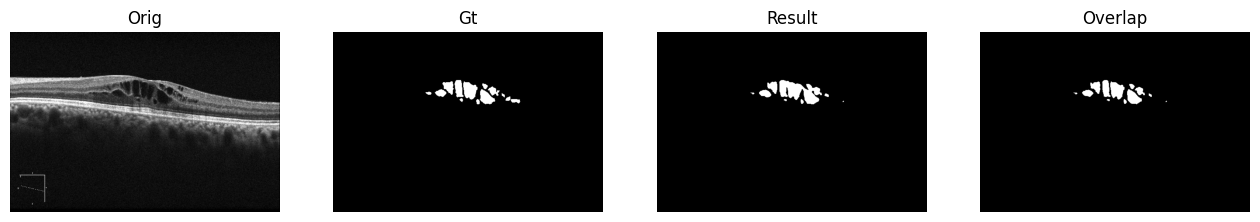

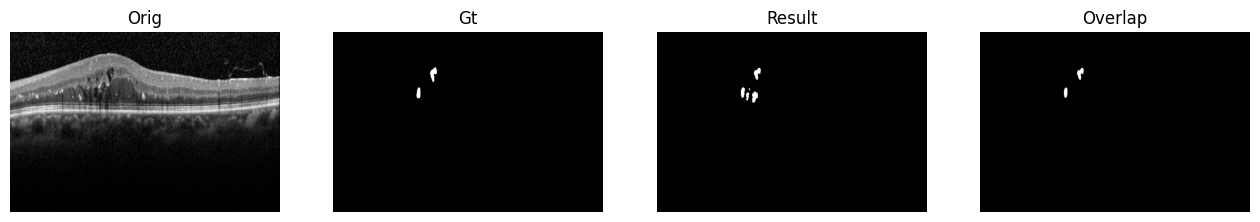

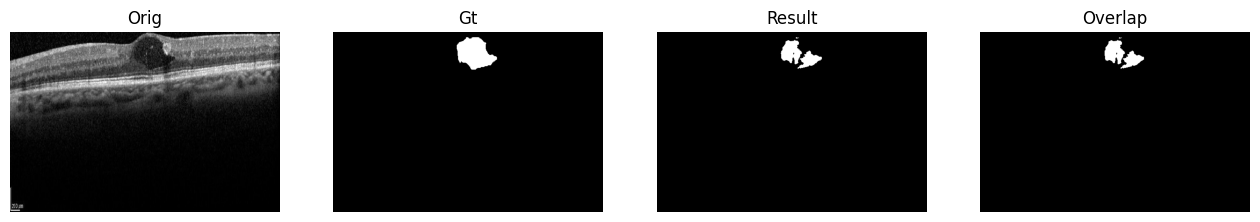


 Métricas en test:
Precision: 0.8003
Recall: 0.8266
Iou: 0.6681
Dice: 0.7931
Specificity: 0.9985


In [30]:
model_bn_aug = UNet(1, 1, use_bn=True).to(device)
criterion = TverskyLoss()
optimizer = torch.optim.Adam(model_bn_aug.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    model_bn_aug,
    train_augmentated_loader,  # Augmentation
    val_loader,
    TverskyLoss(),
    optimizer,
    device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("UNet + TverskyLoss + Augmentation + BatchNorm")
evaluate_model(model_bn_aug, test_loader, device, threshold=0.5, num_examples=3)


## UNet + DiceLoss + Augmentation
Se incorpora data augmentation al modelo con DiceLoss para aumentar la variabilidad del conjunto de entrenamiento. Sin embargo, el rendimiento global empeora respecto al modelo con DiceLoss sin augmentación, lo que sugiere que el aumento artificial no resulta beneficioso en este caso.

Epoch 1/200 | Train Loss: 0.9702 | Val Loss: 0.9664 | Val Dice: 0.0355
Epoch 2/200 | Train Loss: 0.9597 | Val Loss: 0.9597 | Val Dice: 0.0592
Epoch 3/200 | Train Loss: 0.9364 | Val Loss: 0.8736 | Val Dice: 0.1364
Epoch 4/200 | Train Loss: 0.7902 | Val Loss: 0.5104 | Val Dice: 0.5317
Epoch 5/200 | Train Loss: 0.6416 | Val Loss: 0.4702 | Val Dice: 0.5916
Epoch 6/200 | Train Loss: 0.5592 | Val Loss: 0.3381 | Val Dice: 0.7404
Epoch 7/200 | Train Loss: 0.5098 | Val Loss: 0.3142 | Val Dice: 0.7732
Epoch 8/200 | Train Loss: 0.4711 | Val Loss: 0.2843 | Val Dice: 0.8036
Epoch 9/200 | Train Loss: 0.4445 | Val Loss: 0.5996 | Val Dice: 0.4454
Epoch 10/200 | Train Loss: 0.4290 | Val Loss: 0.2972 | Val Dice: 0.7783
Epoch 11/200 | Train Loss: 0.3628 | Val Loss: 0.2324 | Val Dice: 0.8342
Epoch 12/200 | Train Loss: 0.4054 | Val Loss: 0.3074 | Val Dice: 0.7499
Epoch 13/200 | Train Loss: 0.4104 | Val Loss: 0.2213 | Val Dice: 0.8514
Epoch 14/200 | Train Loss: 0.3557 | Val Loss: 0.4285 | Val Dice: 0.6491
E

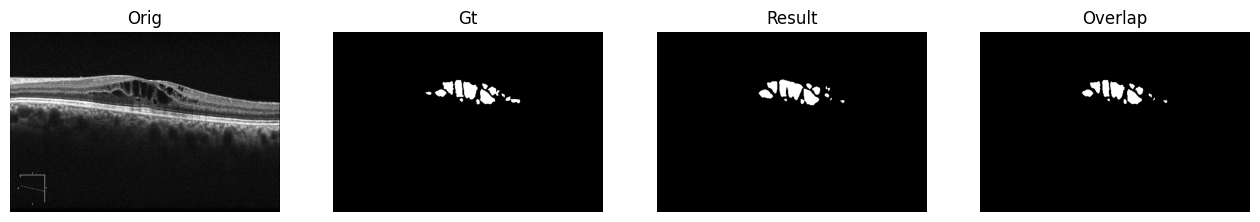

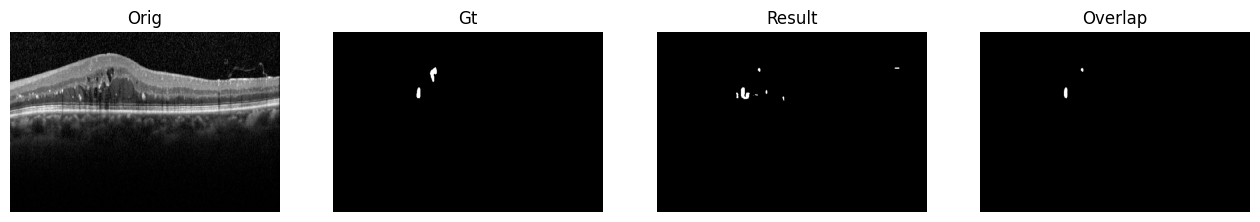

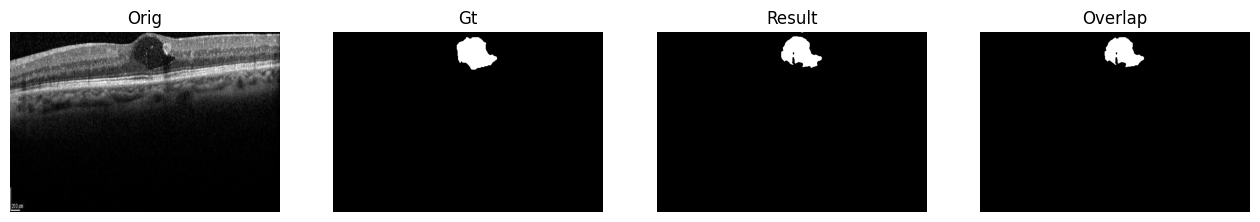


 Métricas en test:
Precision: 0.7386
Recall: 0.7839
Iou: 0.6424
Dice: 0.7563
Specificity: 0.9980


In [14]:
model_aug_dice = UNet(1, 1).to(device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(model_aug_dice.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    model_aug_dice,
    train_augmentated_loader,  
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("UNet + DiceLoss + Augmentation")
evaluate_model(model_aug_dice, test_loader, device, threshold=0.5, num_examples=3)


## UNet + DiceLoss + BatchNorm
Se añade Batch Normalization al modelo con DiceLoss para mejorar la estabilidad del entrenamiento. Esta configuración logra el mejor rendimiento global, superando tanto al baseline como al modelo original con DiceLoss, con el mayor Dice e IoU obtenidos hasta ahora.

Epoch 1/200 | Train Loss: 0.9363 | Val Loss: 0.9749 | Val Dice: 0.0000
Epoch 2/200 | Train Loss: 0.9071 | Val Loss: 0.9744 | Val Dice: 0.0000
Epoch 3/200 | Train Loss: 0.8929 | Val Loss: 0.9285 | Val Dice: 0.1013
Epoch 4/200 | Train Loss: 0.8721 | Val Loss: 0.9531 | Val Dice: 0.0645
Epoch 5/200 | Train Loss: 0.8457 | Val Loss: 0.8952 | Val Dice: 0.1833
Epoch 6/200 | Train Loss: 0.8248 | Val Loss: 0.8210 | Val Dice: 0.5469
Epoch 7/200 | Train Loss: 0.7942 | Val Loss: 0.7756 | Val Dice: 0.7895
Epoch 8/200 | Train Loss: 0.7627 | Val Loss: 0.7537 | Val Dice: 0.6018
Epoch 9/200 | Train Loss: 0.7198 | Val Loss: 0.7293 | Val Dice: 0.6149
Epoch 10/200 | Train Loss: 0.6733 | Val Loss: 0.7620 | Val Dice: 0.4519
Epoch 11/200 | Train Loss: 0.6224 | Val Loss: 0.6649 | Val Dice: 0.5871
Epoch 12/200 | Train Loss: 0.5558 | Val Loss: 0.5950 | Val Dice: 0.6654
Epoch 13/200 | Train Loss: 0.5020 | Val Loss: 0.6012 | Val Dice: 0.5556
Epoch 14/200 | Train Loss: 0.4801 | Val Loss: 0.4723 | Val Dice: 0.7063
E

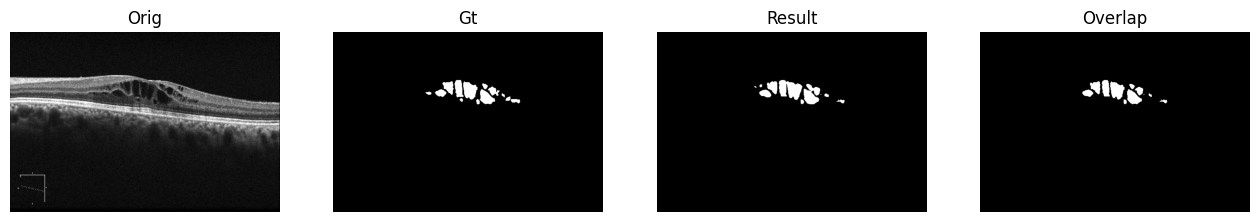

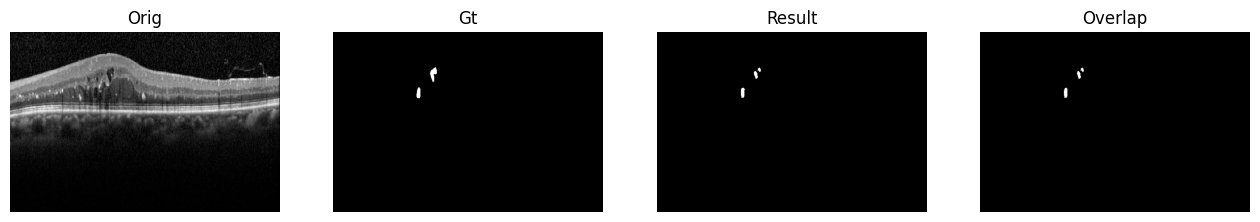

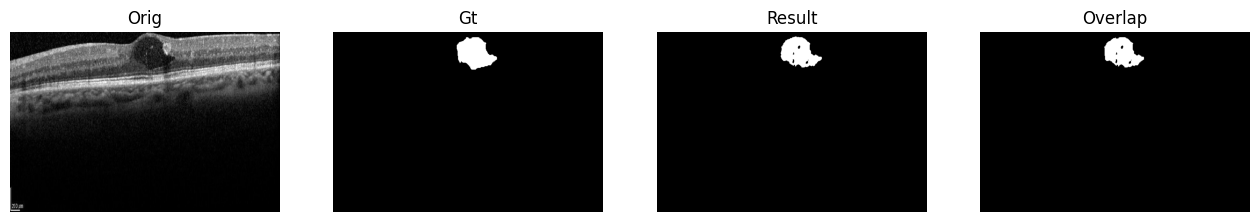


 Métricas en test:
Precision: 0.9110
Recall: 0.8584
Iou: 0.7833
Dice: 0.8756
Specificity: 0.9989


In [17]:
model_bn_dice = UNet(1, 1, use_bn=True).to(device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(model_bn_dice.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    model_bn_dice, train_loader, val_loader,
    criterion, optimizer, device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("UNet + DiceLoss + BatchNorm")
evaluate_model(model_bn_dice, test_loader, device, threshold=0.5, num_examples=3)


## UNet + DiceLoss + Augmentation + BatchNorm
Se combinan data augmentation y Batch Normalization con DiceLoss. Aunque mejora significativamente frente al baseline, no supera al modelo con DiceLoss + BatchNorm sin augmentación, lo que indica que el aumento sintético no aporta beneficio adicional en esta configuración.



Epoch 1/200 | Train Loss: 0.9491 | Val Loss: 0.9733 | Val Dice: 0.0075
Epoch 2/200 | Train Loss: 0.9224 | Val Loss: 0.9509 | Val Dice: 0.0752
Epoch 3/200 | Train Loss: 0.9105 | Val Loss: 0.9475 | Val Dice: 0.0621
Epoch 4/200 | Train Loss: 0.8930 | Val Loss: 0.8733 | Val Dice: 0.3844
Epoch 5/200 | Train Loss: 0.8575 | Val Loss: 0.9572 | Val Dice: 0.0466
Epoch 6/200 | Train Loss: 0.8295 | Val Loss: 0.9540 | Val Dice: 0.0469
Epoch 7/200 | Train Loss: 0.7947 | Val Loss: 0.8346 | Val Dice: 0.5062
Epoch 8/200 | Train Loss: 0.7690 | Val Loss: 0.8550 | Val Dice: 0.1854
Epoch 9/200 | Train Loss: 0.6970 | Val Loss: 0.8064 | Val Dice: 0.3011
Epoch 10/200 | Train Loss: 0.6777 | Val Loss: 0.6717 | Val Dice: 0.5706
Epoch 11/200 | Train Loss: 0.5934 | Val Loss: 0.5996 | Val Dice: 0.7512
Epoch 12/200 | Train Loss: 0.5371 | Val Loss: 0.4463 | Val Dice: 0.8299
Epoch 13/200 | Train Loss: 0.5060 | Val Loss: 0.4383 | Val Dice: 0.6991
Epoch 14/200 | Train Loss: 0.4413 | Val Loss: 0.4093 | Val Dice: 0.7284
E

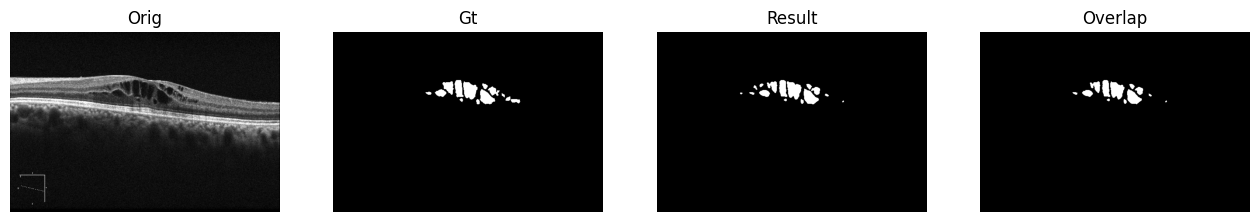

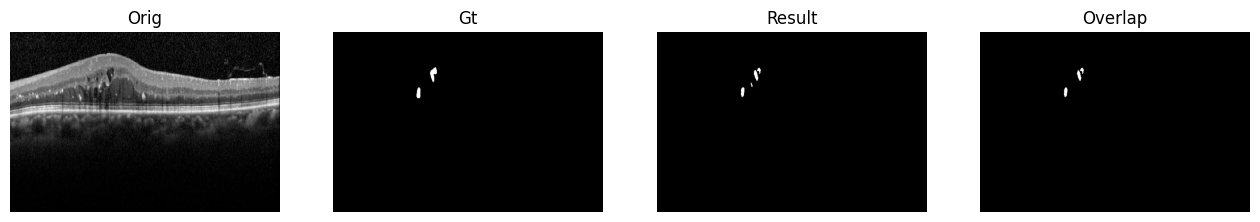

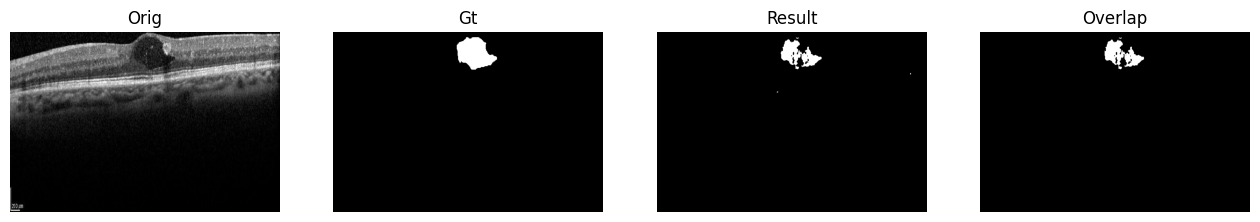


 Métricas en test:
Precision: 0.9002
Recall: 0.7920
Iou: 0.7151
Dice: 0.8319
Specificity: 0.9990


In [18]:
model_bn_aug_dice = UNet(1, 1, use_bn=True).to(device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(model_bn_aug_dice.parameters(), lr=1e-3)

early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)

trained_model = train_model(
    model_bn_aug_dice,
    train_augmentated_loader,  # Augmentation
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=200,
    threshold=0.5,
    early_stopper=early_stopping
)
print("UNet + DiceLoss + Augmentation + BatchNorm")
evaluate_model(model_bn_aug_dice, test_loader, device, threshold=0.5, num_examples=3)


## Conclusiones:

A lo largo de los experimentos, se han evaluado distintas configuraciones de entrenamiento para la segmentación de fluido patológico en imágenes OCT usando UNet. Los resultados muestran que:

- La elección de la función de pérdida tiene un impacto crítico. DiceLoss demostró ser la más efectiva en escenarios con fuerte desbalance de clases.

- La combinación de DiceLoss con Batch Normalization ofreció el mejor rendimiento global, con un valor Dice de 0.8756.

- La data augmentation, en este caso, no mejoró los resultados y, combinada con otras técnicas, incluso redujo el rendimiento en algunos casos.

- Otras funciones como TverskyLoss o FocalLoss ofrecen buenos resultados, pero no superan a las configuraciones con DiceLoss.